In [75]:
import numpy as np
import pandas as pd
# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf')
sns.set(style='ticks', palette=colors)

sns.set_context('talk',font_scale=2,rc={'lines.linewidth':3})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from IPython.core.debugger import set_trace

# For plot fonts and latex rendering
plt.rcParams.update({
    "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]
})

## Here we make everything in terms of X 

In [76]:
import cvxpy
import numpy as np
import scipy as sp
from scipy import sparse

# Discrete time model of simple glycolysis

def v_func(x,u,A,B,K):
    c=np.exp(A.dot(np.log(x))+B.dot(u))
    v=K.dot(c)
    return v

def f_func(v,w,S,Sw):
    f=S.dot(v)+Sw.dot(w)
    return f

def AdBd_func(dt,x,u,w,A,B,K,S,Sw):
    v=v_func(x,u,A,B,K)
    f0=f_func(v,w,S,Sw)
    
    Ac=S.dot(np.diag(v)).dot(A).dot(np.diag(1/x))
    Bc=S.dot(np.diag(v)).dot(B)
    return Ac*dt+np.eye(Ac.shape[0]),Bc*dt,f0*dt

a=1
q=1
k=1
K=np.diag([2,2*k])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]])
Sw=np.array([0,-1])


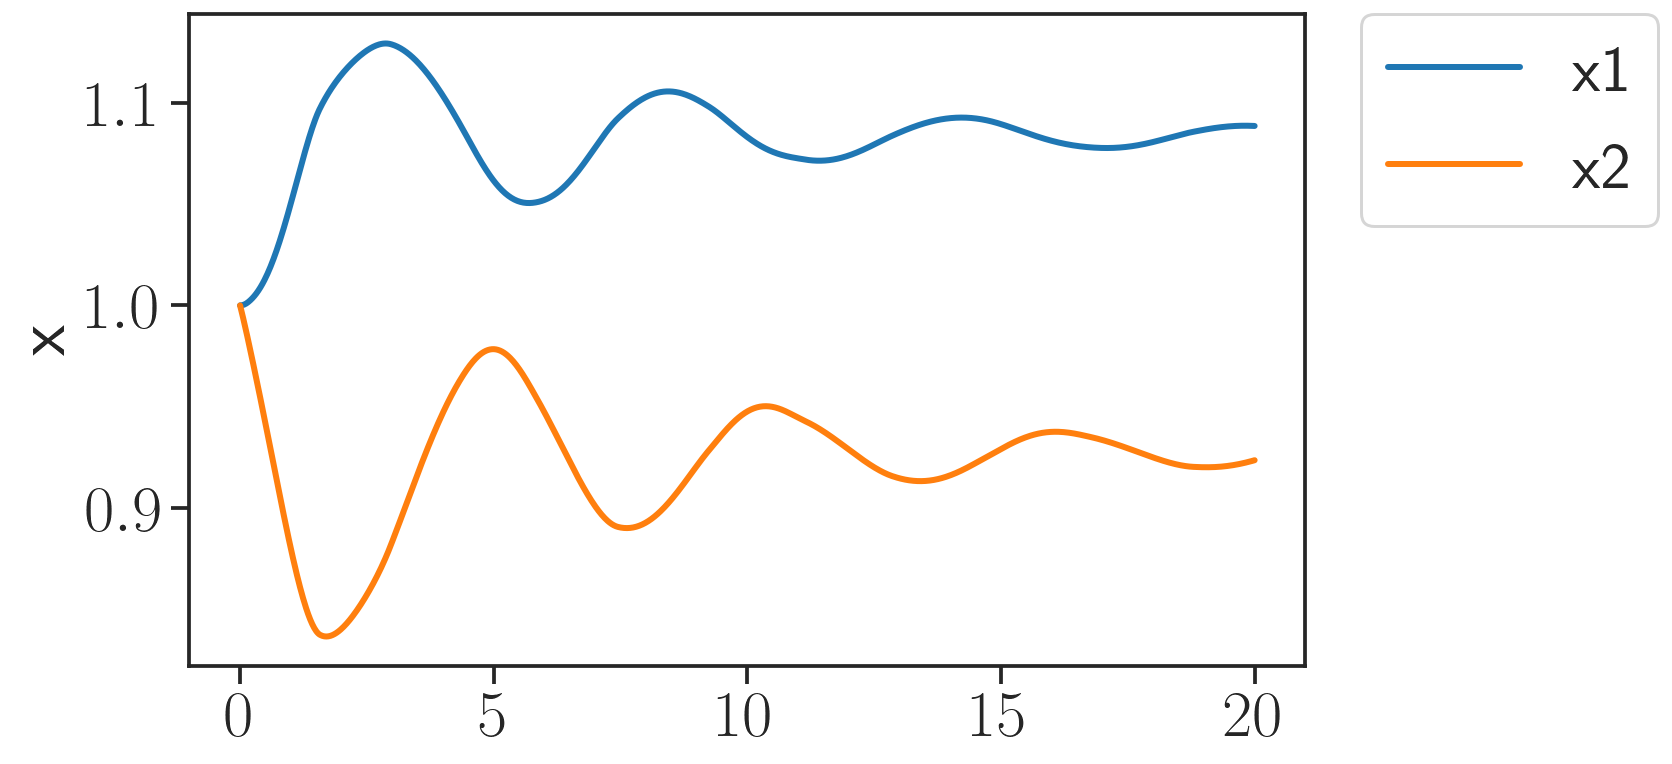

In [77]:
# def c1_func_real(x,params):
#     a=params['a']
#     h=params['h']
#     return np.array([x[1]**a/(1+x[1]**(2*h))])

# def df(x,S0,S1,k0,k1,c0_func,c1_func,w,params):
#     return S0.dot(k0).dot(c0_func(x,params))+S1.dot(k1).dot(c1_func(x,params))-w

# f=lambda t,x:df(x,S0,S1,k0,k1,c0_func,c1_func_real,w,params)

def df(x,a,h,g,k,q,delta):
    cpfk=x[1]**a/(1+x[1]**(2*h))
    cpk=x[0]/(1+x[1]**(2*g))
    return [2*cpfk-2*k*cpk, -q*2*cpfk+(q+1)*2*k*cpk-delta]

a=1
h=2.5
g=0.2
k=1
q=1
delta=1.1
f=lambda t,x:df(x,a,h,g,k,q,delta)
from scipy.integrate import solve_ivp
x0=[1/k,1]
t=np.linspace(0,20,1000)
sol = solve_ivp(f, [0,100], x0,t_eval=t)

fig, ax = plt.subplots(1, 1,figsize=(10,6))
ax.plot(sol.t,sol.y[0],label='x1')
ax.plot(sol.t,sol.y[1],label='x2')
ax.set_ylabel('x')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)   
# plt.savefig('glycolysis-closedloop-oscillate.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

/home/chemaoxfz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


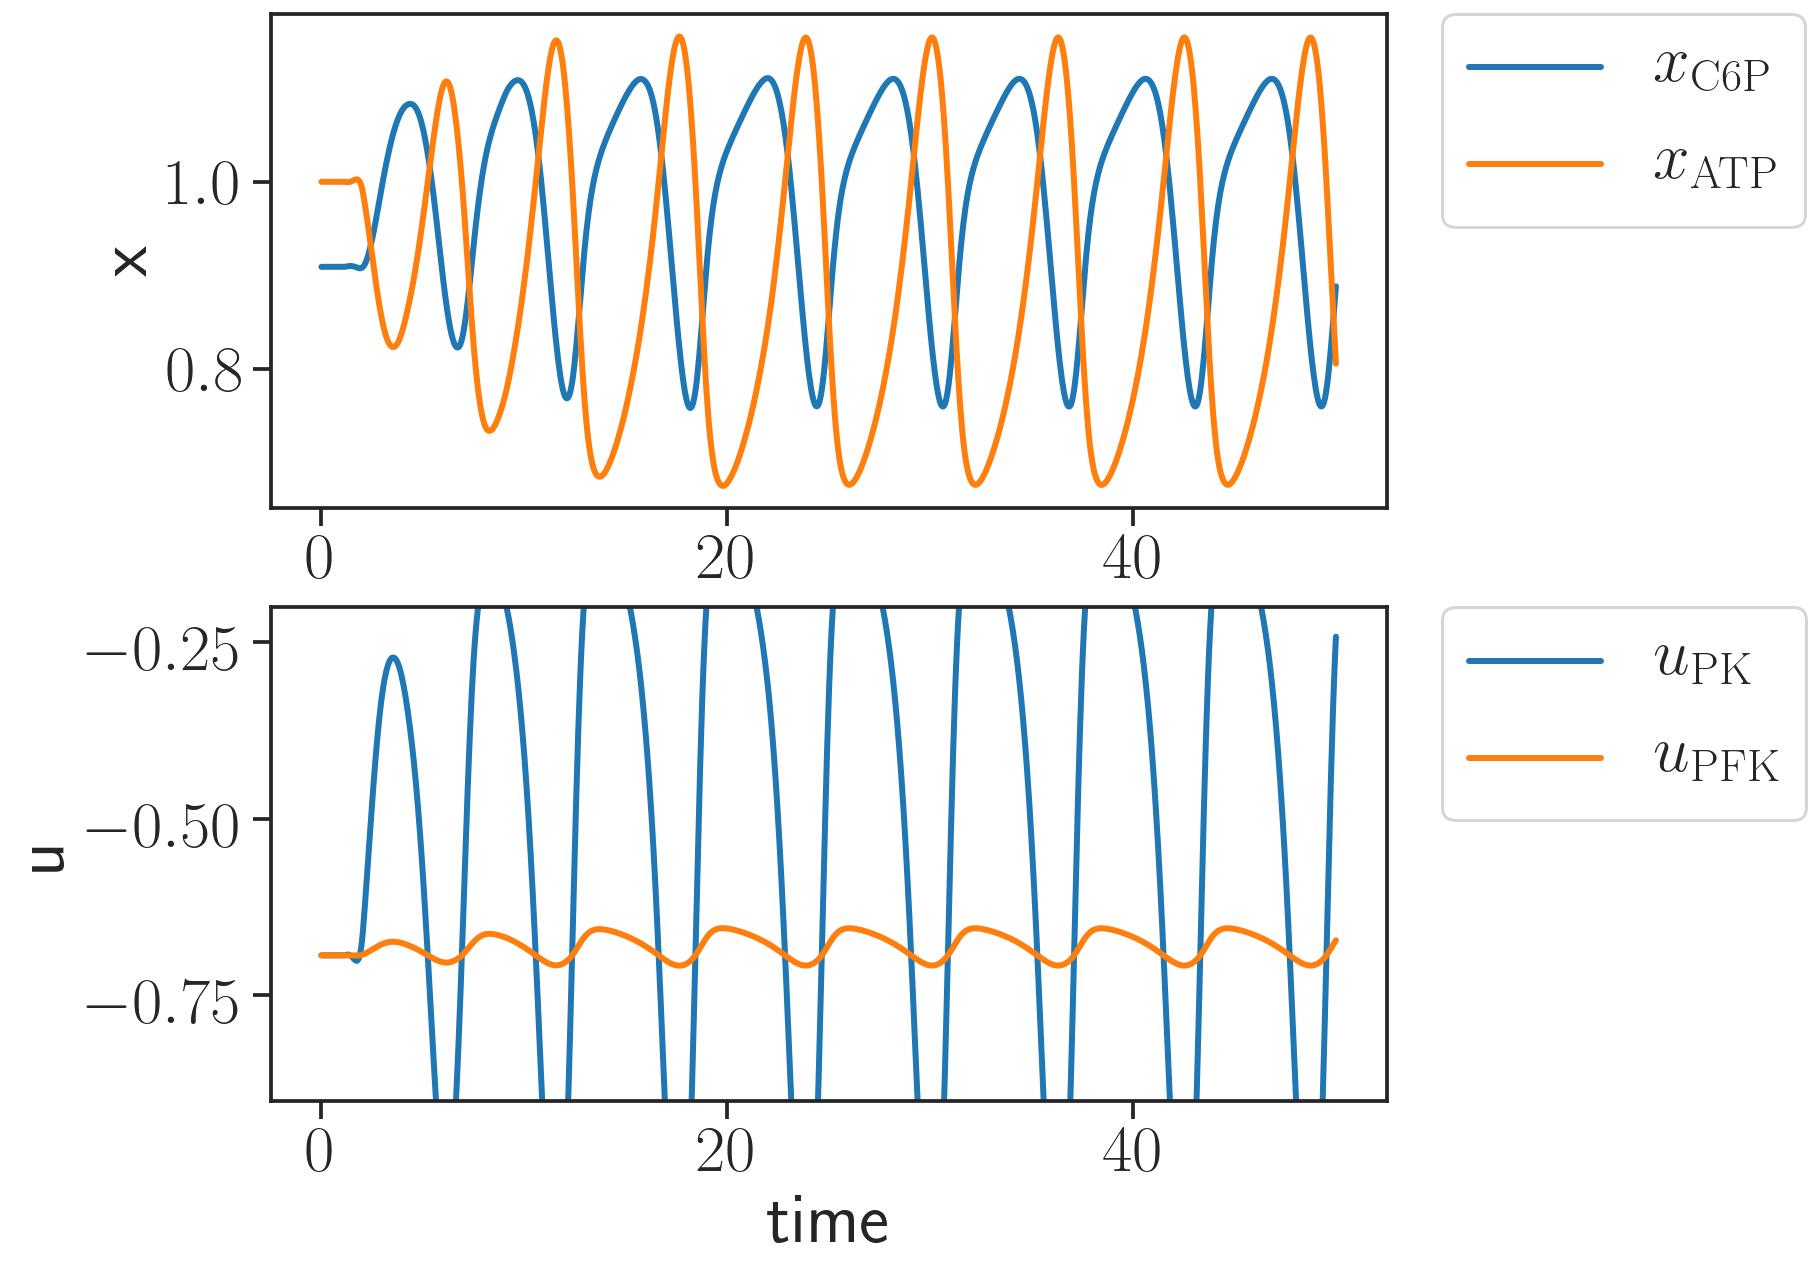

In [4]:
a=1
q=1
k=1.1
K=np.diag([2,2*k])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]])
Sw=np.array([0,-1])
w_func=lambda t:1+(t>2)*0.1

h=3
g=.1

def df2(t,x,w_func,S,K,Sw):
    c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])
    v=K.dot(c)
    return S.dot(v)+Sw.dot(w_func(t))

f=lambda t,x:df2(t,x,w_func,S,K,Sw)
from scipy.integrate import solve_ivp
x0=[1/k,1]
t=np.linspace(0,50,1000)
sol = solve_ivp(f, [0,100], x0, t_eval=t)

xtraj=sol.y
utraj=np.array([np.log(1/(1+xtraj[1]**(2*h))),np.log(1/(1+xtraj[1]**(2*g)))])

fig, ax = plt.subplots(2, 1,figsize=(10,10))
ax[0].plot(t,xtraj[0],label=r'\(x_{\mathrm{C6P}}\)')
ax[0].plot(t,xtraj[1],label=r'\(x_{\mathrm{ATP}}\)')
ax[0].set_ylabel('x')
# ax[0].set_ylim([0.8,1.2])
ax[1].plot(t,utraj[0],label=r'\(u_{\mathrm{PK}}\)')
ax[1].plot(t,utraj[1],label=r'\(u_{\mathrm{PFK}}\)')
ax[1].set_xlabel('time')
ax[1].set_ylabel('u')
ax[1].set_ylim([-0.9,-0.2])
handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
handles, labels = ax[1].get_legend_handles_labels()
lgd = ax[1].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
plt.savefig('glycolysis-closedloop-oscillate.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

#### In the following we check whether our linearization works by simulating the same dynamics using linearized variables.

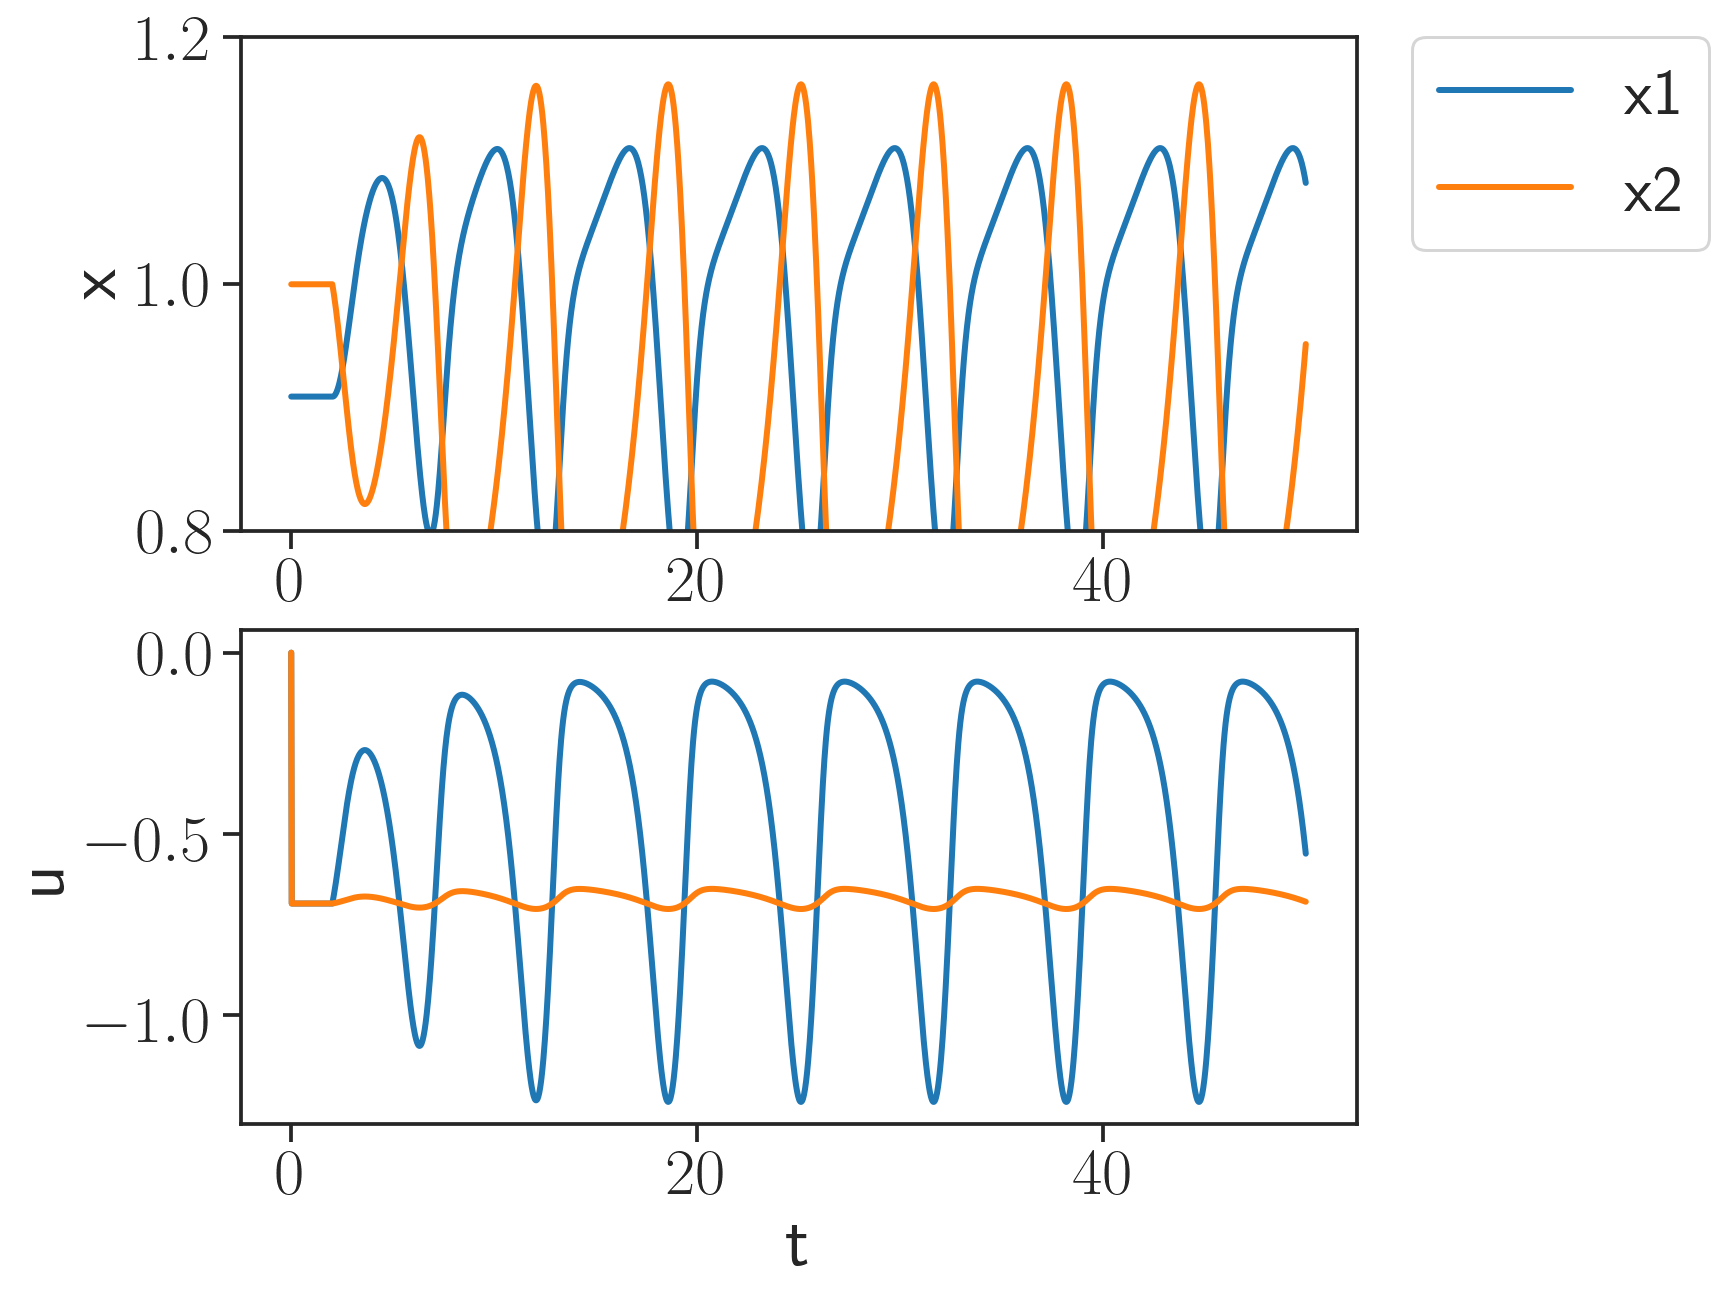

In [5]:
x0=np.array([1/k,1])
u0=np.array([0,0])
x_current=x0
nsim=2000
dt=0.025
u_current=np.array([np.log(1/(1+x_current[1]**(2*h))),np.log(1/(1+x_current[1]**(2*g)))]) #assuming we know u
xtraj=np.zeros([x0.shape[0],nsim+1])
utraj=np.zeros([u0.shape[0],nsim+1])
xtraj[:,0]=x0
utraj[:,0]=u0

w_func=lambda t:1+(t>2)*0.1

# CHECKING FOR LINEARIZATION
for i in range(nsim):
    t=i*dt
    w_current=w_func(t)
    Ad,Bd,bb=AdBd_func(dt,x_current,u_current,w_current,A,B,K,S,Sw)
    dx=bb # changes of z only comes from zeroth order term, as first order terms are zero at the very beginning.
    x_current=x_current+dx
    u_current=np.array([np.log(1/(1+x_current[1]**(2*h))),np.log(1/(1+x_current[1]**(2*g)))])
    xtraj[:,i+1]=x_current
    utraj[:,i+1]=u_current

    
fig, ax = plt.subplots(2, 1,figsize=(10,10))
t=dt*np.arange(nsim+1)
ax[0].plot(t,xtraj[0],label='x1')
ax[0].plot(t,xtraj[1],label='x2')
ax[0].set_ylabel('x')
ax[0].set_ylim([0.8,1.2])
ax[1].plot(t,utraj[0],label='u1')
ax[1].plot(t,utraj[1],label='u2')
ax[1].set_xlabel('t')
ax[1].set_ylabel('u')
handles, labels = ax[0].get_legend_handles_labels()
lgd = ax[0].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)

In [29]:
a=1
q=1
k_param=1.1
K=np.diag([2,2*k_param])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]])
Sw=np.array([0,-1])

[nx, nu] = [2,2]

# Constraints
# Note that since the optimization variables are changes in x and u,
# the constraints are on the changes of x and u.
dumin = np.array([-np.inf,-np.inf])
dumax = np.array([np.inf,np.inf])
# xmin = np.array([0,0])
# xmax = np.array([ np.inf, np.inf])
xmin=np.array([0.1,0.6])
xmax=np.array([np.inf,np.inf])

# Objective function
Q = sparse.diags([.1, 0.1])
QN = Q
R=sparse.diags([.1,1])
# Initial and reference states
x0 = np.array([1/k_param,1])
u0 = np.array([-.695,-.695])

# Prediction horizon
N = 20

# Define problem
du = cvxpy.Variable((nu, N))
dx = cvxpy.Variable((nx, N+1))
x_init = cvxpy.Parameter(nx)
u_init=cvxpy.Parameter(nu)
xr = cvxpy.Parameter(nx)
Ad=cvxpy.Parameter((nx,nx))
Bd=cvxpy.Parameter((nx,nu))
bb=cvxpy.Parameter(nx)
objective = 0
constraints = [dx[:,0] == np.zeros(2)]
#the optimization variable dx is predicted change to x_init, so x_init+dx(t) = x(t).
for k in range(N):
    #penalize deviation of x from xr
    #penalize changes in u.
    objective += cvxpy.quad_form(x_init+dx[:,k] - xr, Q) + cvxpy.quad_form(du[:,k], R) 
    constraints += [dx[:,k+1] == bb + Ad@dx[:,k] + Bd@du[:,k]]
    constraints += [xmin <= x_init+dx[:,k], x_init+dx[:,k] <= xmax]
    constraints += [dumin <= du[:,k], du[:,k] <= dumax]
# objective += cvxpy.quad_form(cvxpy.atoms.sum(x,axis=1) - xr, QN)
prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints)

In [30]:
# Simulate in closed loop
t_init=0
t_end=50
dt=.05
nsim = int(t_end/dt)
w_func=lambda t:1+(t>10)*0.1
x1r_func=lambda t:1-(t>10)*0.05
x0r_func=lambda t:1/k_param+(t>10)*0.05
xr.value=np.array([1/k_param,1])
# R_diag_list=[[0.1,2.0],[0.1,1.5],[0.1,1.0]]
R_diag_list=[[0.1,1.0]]

n_params=len(R_diag_list)


xtraj=np.zeros([x0.shape[0],nsim+1])
utraj=np.zeros([u0.shape[0],nsim+1])
vtraj=np.zeros([u0.shape[0],nsim+1])
x_now=x0
u_now=u0
xtraj[:,0]=x_now
utraj[:,0]=u_now
v_now=np.exp(A.dot(np.log(x_now))+B.dot(u_now))
vtraj[:,0]=v_now
for i in range(nsim):
    x_init.value = x_now
    u_init.value=u_now
    t=i*dt
    w=w_func(t)
    xr.value=np.array([x0r_func(t),x1r_func(t)])
    #We calculate reference value by v_pk = w, so v_pk = k_2 * x_1 = w, so x_1 = w/k_2
    #Also, v_pk = v_pdfk, so k_1 x_2**a = w, so x_2 = (w/k_1)**(1/a)
    #Note that this changes with any changes of these parameters
#     xr.value=np.array([w/(K[1,1]/2), (w/(K[0,0]/2))**(1/a)])
#     set_trace()
    try:
        Ad.value,Bd.value,bb.value= AdBd_func(dt,x_now,u_now,w,A,B,K,S,Sw) #linearize at current position
    except:
        set_trace()
    prob.solve(solver=cvxpy.OSQP,warm_start=True) #solve LQR based on linearized model for optimal strategy to use at current step
    u_now=u_now+du[:,0].value #first step of optimal control is applied. uu is change in u.
#     set_trace()
    x_now=x_now+bb.value
    xtraj[:,i+1]=x_now
    utraj[:,i+1]=u_now
    v_now=np.exp(A.dot(np.log(x_now))+B.dot(u_now))
    vtraj[:,i+1]=v_now


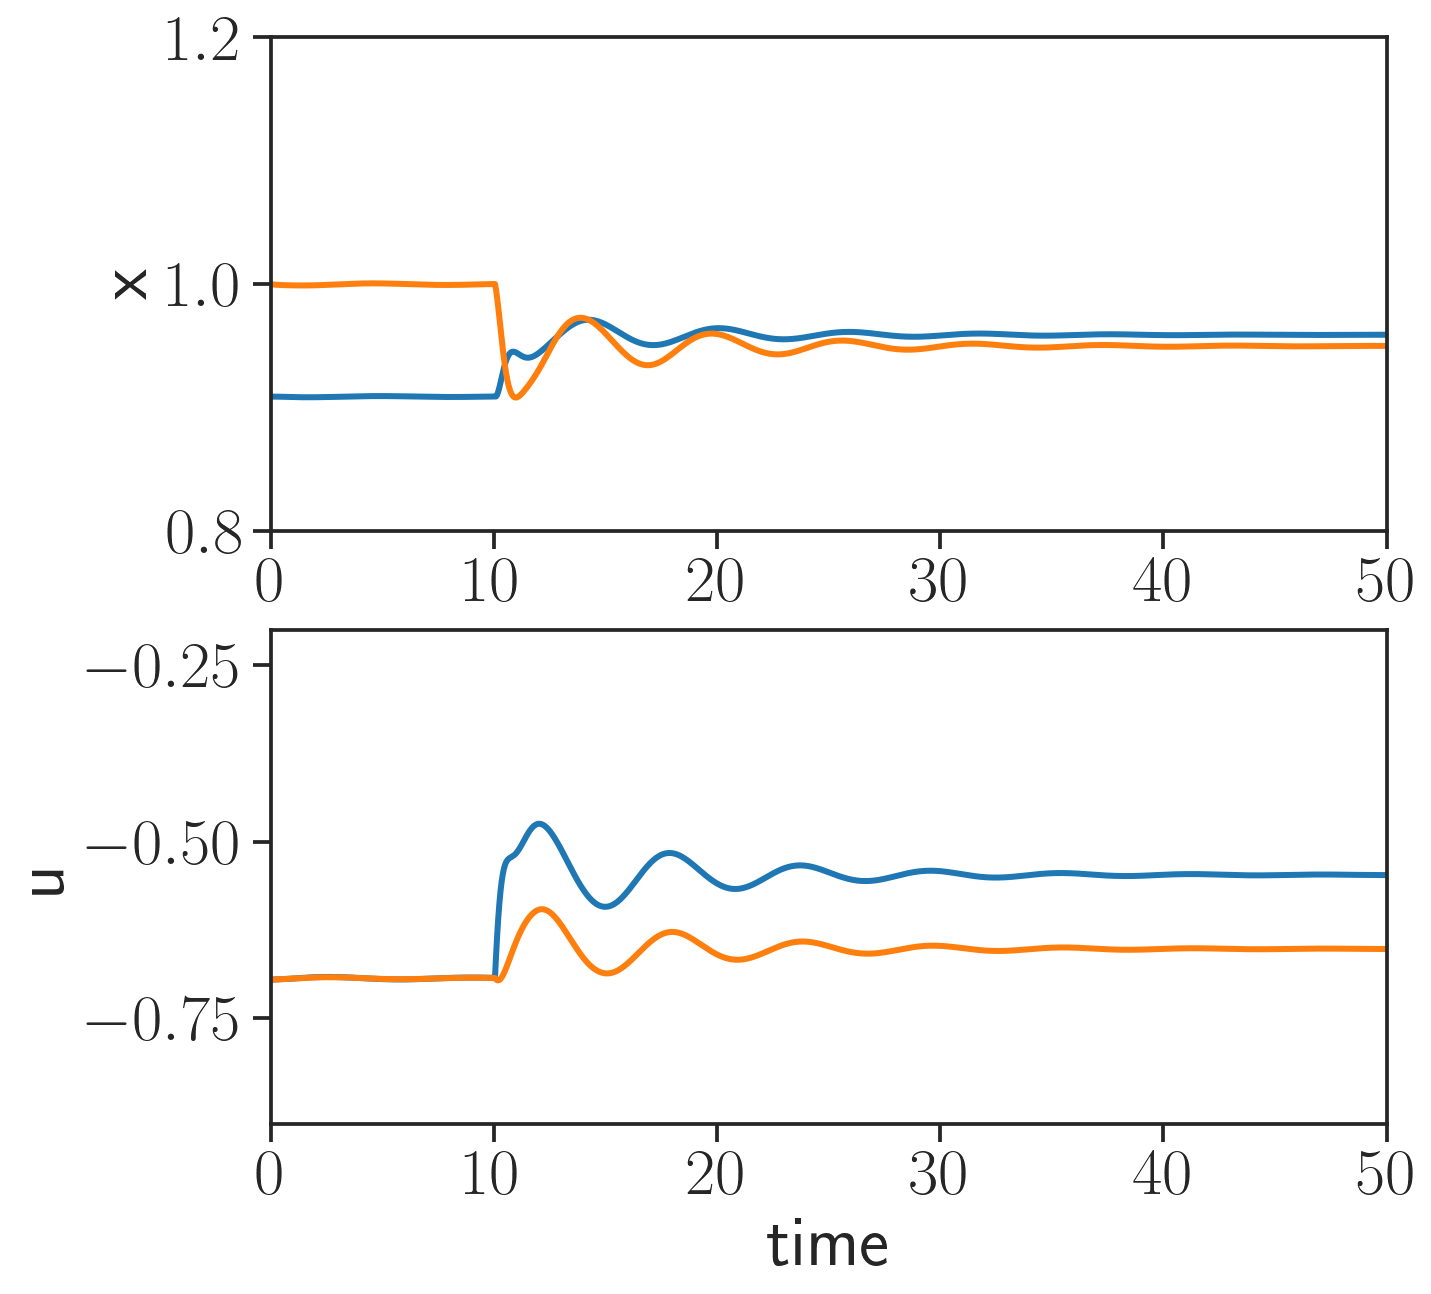

In [31]:
fig, ax = plt.subplots(2, 1,figsize=(10,10))
t=dt*np.arange(xtraj.shape[1])
ax[0].plot(t,xtraj[0],label='x1')
ax[0].plot(t,xtraj[1],label='x2')
ax[0].set_ylabel('x')
ax[0].set_ylim([0.8,1.2])
ax[0].set_xlim([0,50])
ax[1].plot(t,utraj[0],label='u1')
ax[1].plot(t,utraj[1],label='u2')
ax[1].set_xlabel('time')
ax[1].set_ylim([-0.9,-0.2])
ax[1].set_ylabel('u')
ax[1].set_xlim([0,50])
handles, labels = ax[0].get_legend_handles_labels()
# lgd = ax[0].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
# plt.savefig('glycolysis-mpc-oscillate.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

/home/chemaoxfz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


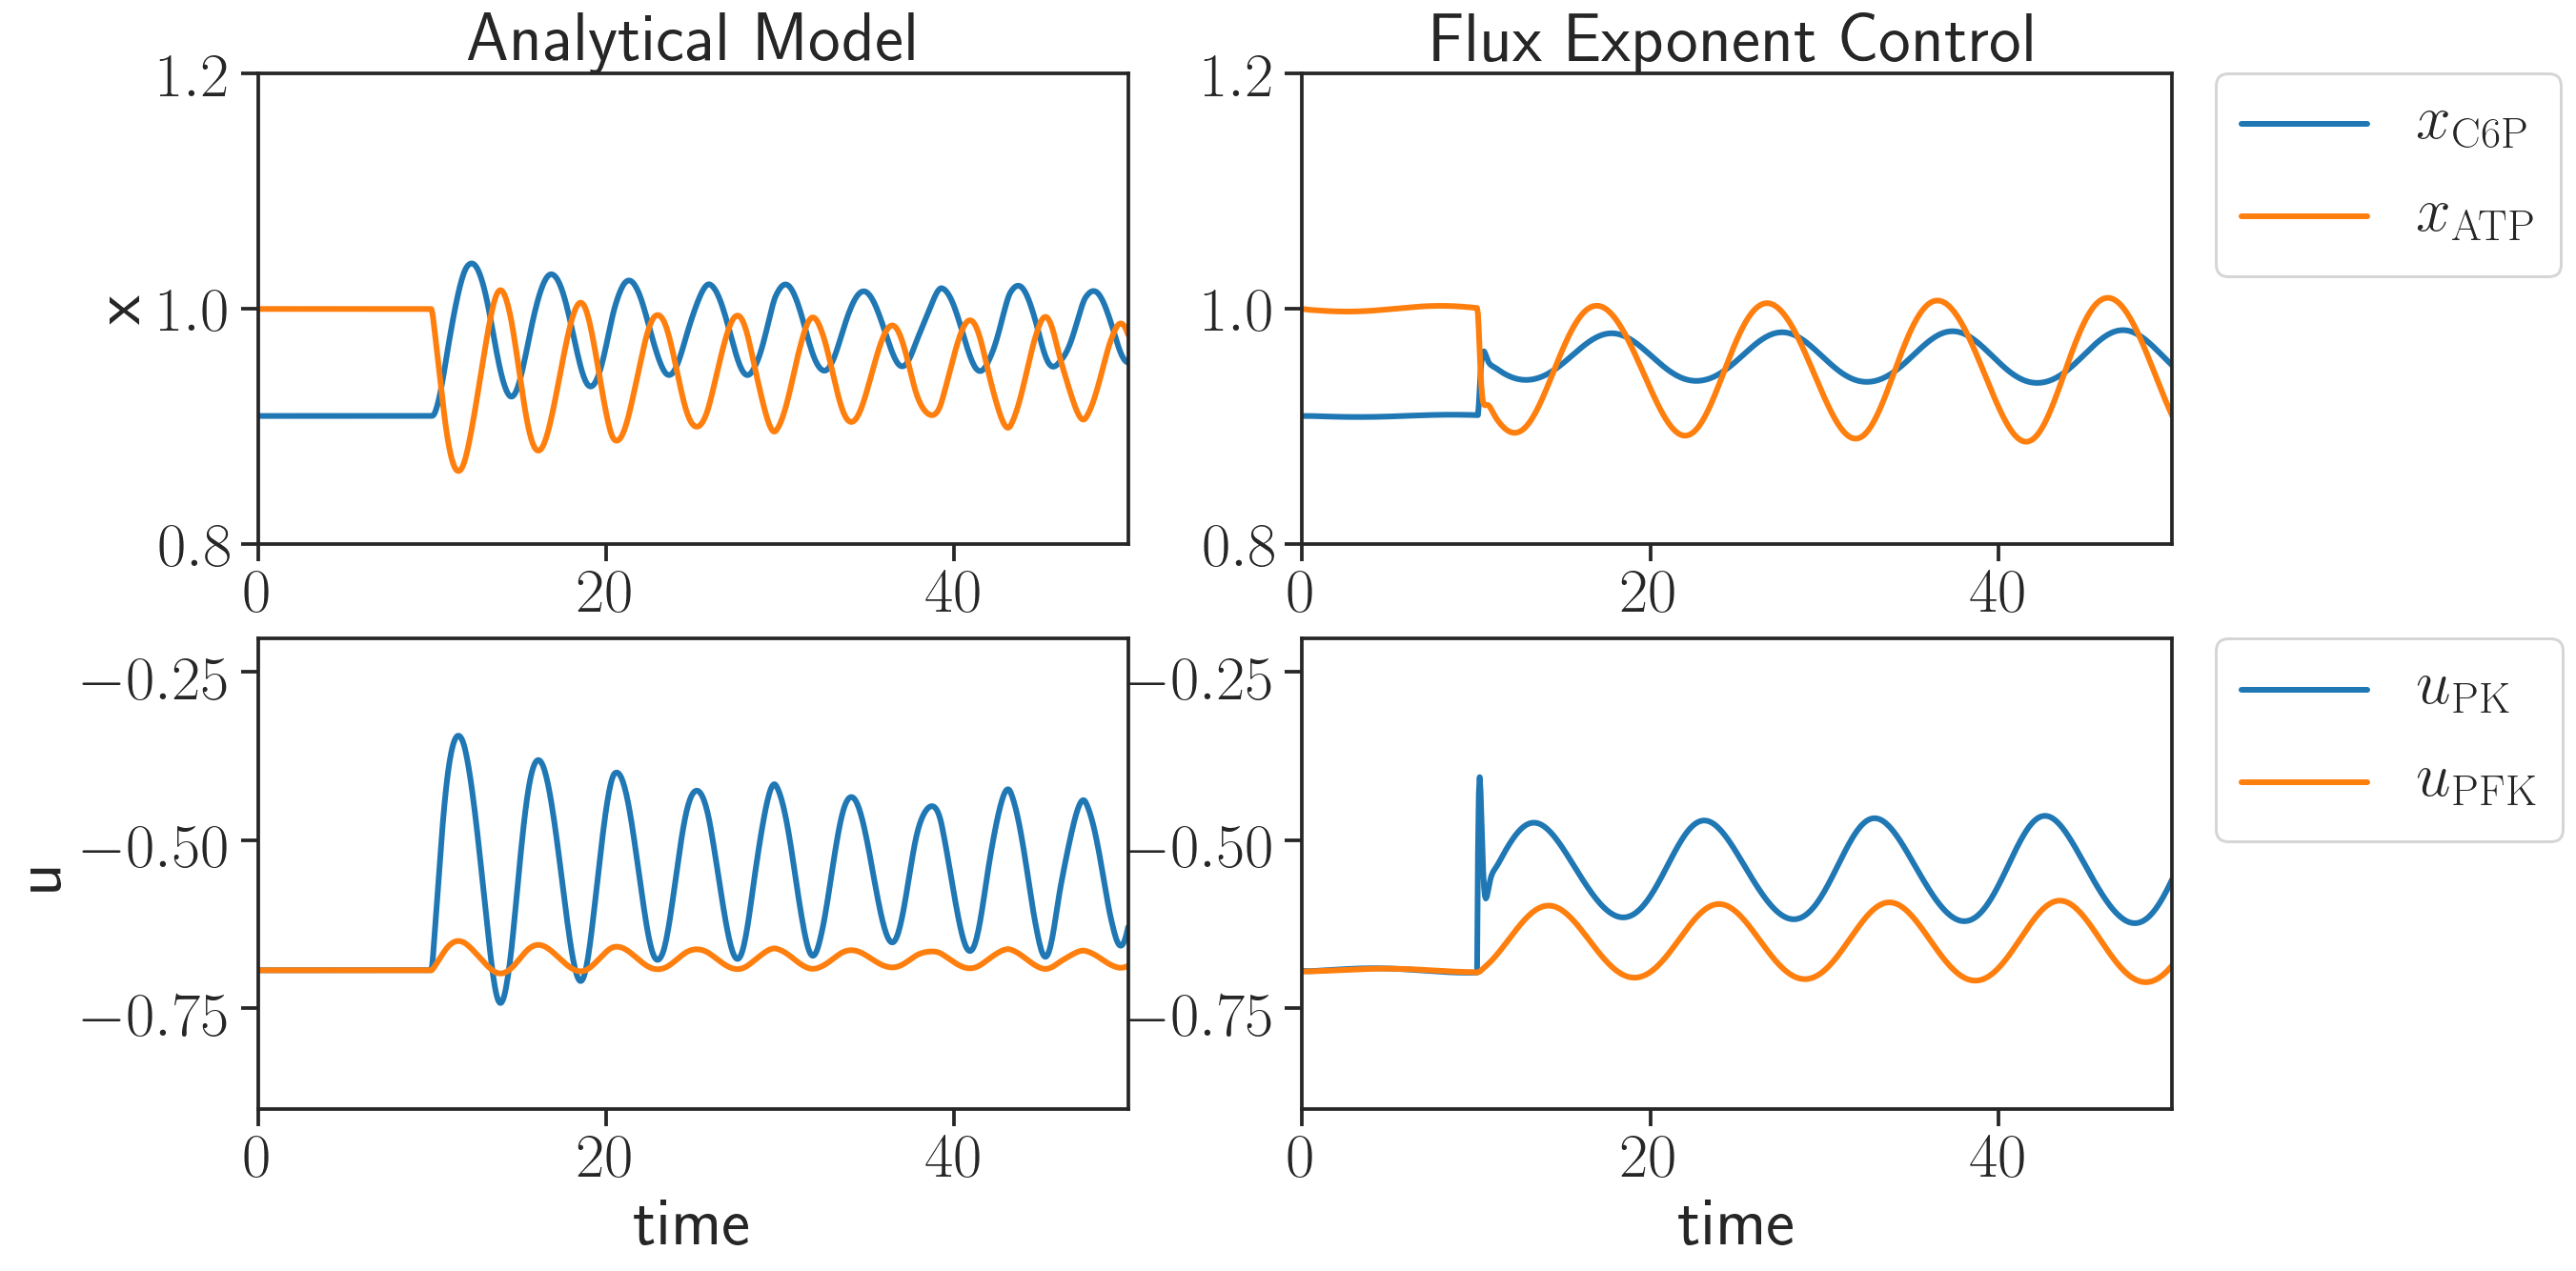

In [18]:
a=1
q=1
k=1.1
K=np.diag([2,2*k])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]])
Sw=np.array([0,-1])
w_func=lambda t:1+(t>10)*0.1
# w_func=lambda t:1.1

h=3
g=.3

def df2(t,x,w_func,S,K,Sw):
    c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])
    v=K.dot(c)
    return S.dot(v)+Sw.dot(w_func(t))

f=lambda t,x:df2(t,x,w_func,S,K,Sw)
from scipy.integrate import solve_ivp
x0=[1/k,1]
t_true=np.linspace(0,50,1000)
sol = solve_ivp(f, [0,100], x0, t_eval=t_true)

xtraj_true=sol.y
utraj_true=np.array([np.log(1/(1+xtraj_true[1]**(2*h))),np.log(1/(1+xtraj_true[1]**(2*g)))])

fig, ax = plt.subplots(2, 2,figsize=(18,10))
ax[0,0].plot(t_true,xtraj_true[0],label=r'\(x_{\mathrm{C6P}}\)')
ax[0,0].plot(t_true,xtraj_true[1],label=r'\(x_{\mathrm{ATP}}\)')
ax[0,0].set_ylabel('x')
ax[0,0].set_ylim([0.8,1.2])
ax[0,0].set_xlim([0,50])
ax[0,0].set_title('Analytical Model')
ax[1,0].plot(t_true,utraj_true[0],label=r'\(u_{\mathrm{PK}}\)')
ax[1,0].plot(t_true,utraj_true[1],label=r'\(u_{\mathrm{PFK}}\)')
ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel('u')
ax[1,0].set_ylim([-0.9,-0.2])
ax[1,0].set_xlim([0,50])

ax[0,1].plot(t,xtraj[0])
ax[0,1].plot(t,xtraj[1])
ax[0,1].set_ylim([0.8,1.2])
ax[0,1].set_xlim([0,50])
ax[0,1].set_title('Flux Exponent Control')
ax[1,1].plot(t,utraj[0])
ax[1,1].plot(t,utraj[1])
ax[1,1].set_xlabel('time')
ax[1,1].set_ylim([-0.9,-0.2])
ax[1,1].set_xlim([0,50])


handles, labels = ax[0,0].get_legend_handles_labels()
lgd0 = ax[0,1].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
handles, labels = ax[1,0].get_legend_handles_labels()
lgd1 = ax[1,1].legend(handles, labels, loc=2, bbox_to_anchor=(1.05,0.,1.,1),borderaxespad=0.0)
plt.savefig('glycolysis-closedloop-oscillate.png', bbox_extra_artists=(lgd0,lgd1), bbox_inches='tight')

In [218]:
a=1
q=1
k_param=1.1
K=np.diag([2,2*k_param])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]])
Sw=np.array([0,-1])

[nx, nu] = [2,2]

# Constraints
# Note that since the optimization variables are changes in x and u,
# the constraints are on the changes of x and u.
dumin = np.array([-np.inf,-np.inf])
dumax = np.array([np.inf,np.inf])
# xmin = np.array([0,0])
# xmax = np.array([ np.inf, np.inf])
xmin=np.array([0.1,0.6])
xmax=np.array([np.inf,np.inf])

t_init=0
t_end=50
dt=.03
nsim = int(t_end/dt)

def MPC(R=sparse.diags([.1,1])):
    t_init=0
    t_end=50
    dt=.03
    nsim = int(t_end/dt)
    
    Q = sparse.diags([.3, .08])
    QN = Q
    # Initial and reference states
    x0 = np.array([1/k_param,1])
    u0 = np.array([-.695,-.695])

    # Prediction horizon
    T=.6
    N=int(T/dt)

    # Define problem
    du = cvxpy.Variable((nu, N))
    dx = cvxpy.Variable((nx, N+1))
    x_init = cvxpy.Parameter(nx)
    u_init=cvxpy.Parameter(nu)
    xr = cvxpy.Parameter(nx)
    Ad=cvxpy.Parameter((nx,nx))
    Bd=cvxpy.Parameter((nx,nu))
    bb=cvxpy.Parameter(nx)
    objective = 0
    constraints = [dx[:,0] == np.zeros(2)]
    #the optimization variable dx is predicted change to x_init, so x_init+dx(t) = x(t).
    for k in range(N):
        #penalize deviation of x from xr
        #penalize changes in u.
        objective += cvxpy.quad_form(x_init+dx[:,k] - xr, Q) + cvxpy.quad_form(du[:,k], R) 
        constraints += [dx[:,k+1] == bb + Ad@dx[:,k] + Bd@du[:,k]]
        constraints += [xmin <= x_init+dx[:,k], x_init+dx[:,k] <= xmax]
        constraints += [dumin <= du[:,k], du[:,k] <= dumax]
    # objective += cvxpy.quad_form(cvxpy.atoms.sum(x,axis=1) - xr, QN)
    prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints)

    # Simulate in closed loop
    w_func=lambda t:1+(t>10)*0.1
    x1r_func=lambda t:1-(t>10)*0.07
    x0r_func=lambda t:1/k_param+(t>10)*0.07
    xr.value=np.array([1/k_param,1])
    xtraj=np.zeros([x0.shape[0],nsim+1])
    utraj=np.zeros([u0.shape[0],nsim+1])
    vtraj=np.zeros([u0.shape[0],nsim+1])
    x_now=x0
    u_now=u0
    xtraj[:,0]=x_now
    utraj[:,0]=u_now
    v_now=K.dot(np.exp(A.dot(np.log(x_now))+B.dot(u_now)))
    vtraj[:,0]=v_now
    for i in range(nsim):
        x_init.value = x_now
        u_init.value=u_now
        t=i*dt
        w=w_func(t)
        xr.value=np.array([x0r_func(t),x1r_func(t)])
        #We calculate reference value by v_pk = w, so v_pk = k_2 * x_1 = w, so x_1 = w/k_2
        #Also, v_pk = v_pdfk, so k_1 x_2**a = w, so x_2 = (w/k_1)**(1/a)
        #Note that this changes with any changes of these parameters
    #     xr.value=np.array([w/(K[1,1]/2), (w/(K[0,0]/2))**(1/a)])
    #     set_trace()
        try:
            Ad.value,Bd.value,bb.value= AdBd_func(dt,x_now,u_now,w,A,B,K,S,Sw) #linearize at current position
        except:
            set_trace()
        prob.solve(solver=cvxpy.OSQP,warm_start=True) #solve LQR based on linearized model for optimal strategy to use at current step
        u_now=u_now+du[:,0].value #first step of optimal control is applied. uu is change in u.
    #     set_trace()
        x_now=x_now+bb.value
        xtraj[:,i+1]=x_now
        utraj[:,i+1]=u_now
        v_now=K.dot(np.exp(A.dot(np.log(x_now))+B.dot(u_now)))
        vtraj[:,i+1]=v_now
    t=dt*np.arange(xtraj.shape[1])
    return xtraj,utraj,vtraj,t

# R_list=[sparse.diags([.1,1.5]),sparse.diags([.1,2.0]),sparse.diags([.1,2.5])]
# R_list=[sparse.diags([.4,.5])]
R_list=[sparse.diags([.4,.05]),sparse.diags([.4,.25]),sparse.diags([.4,.45])]
nMPC_params=len(R_list)
xMPC_traj_list=np.zeros([nMPC_params,2,nsim+1])
uMPC_traj_list=np.zeros([nMPC_params,2,nsim+1])
vMPC_traj_list=np.zeros([nMPC_params,2,nsim+1])
for i,R in zip(range(nMPC_params),R_list):
    xMPC_traj,uMPC_traj,vMPC_traj,tMPC=MPC(R)
    xMPC_traj_list[i]=xMPC_traj
    uMPC_traj_list[i]=uMPC_traj
    vMPC_traj_list[i]=vMPC_traj
print('done')

done


<ipython-input-219-449c78d9490a>:23: RuntimeWarning: invalid value encountered in double_scalars
  c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])


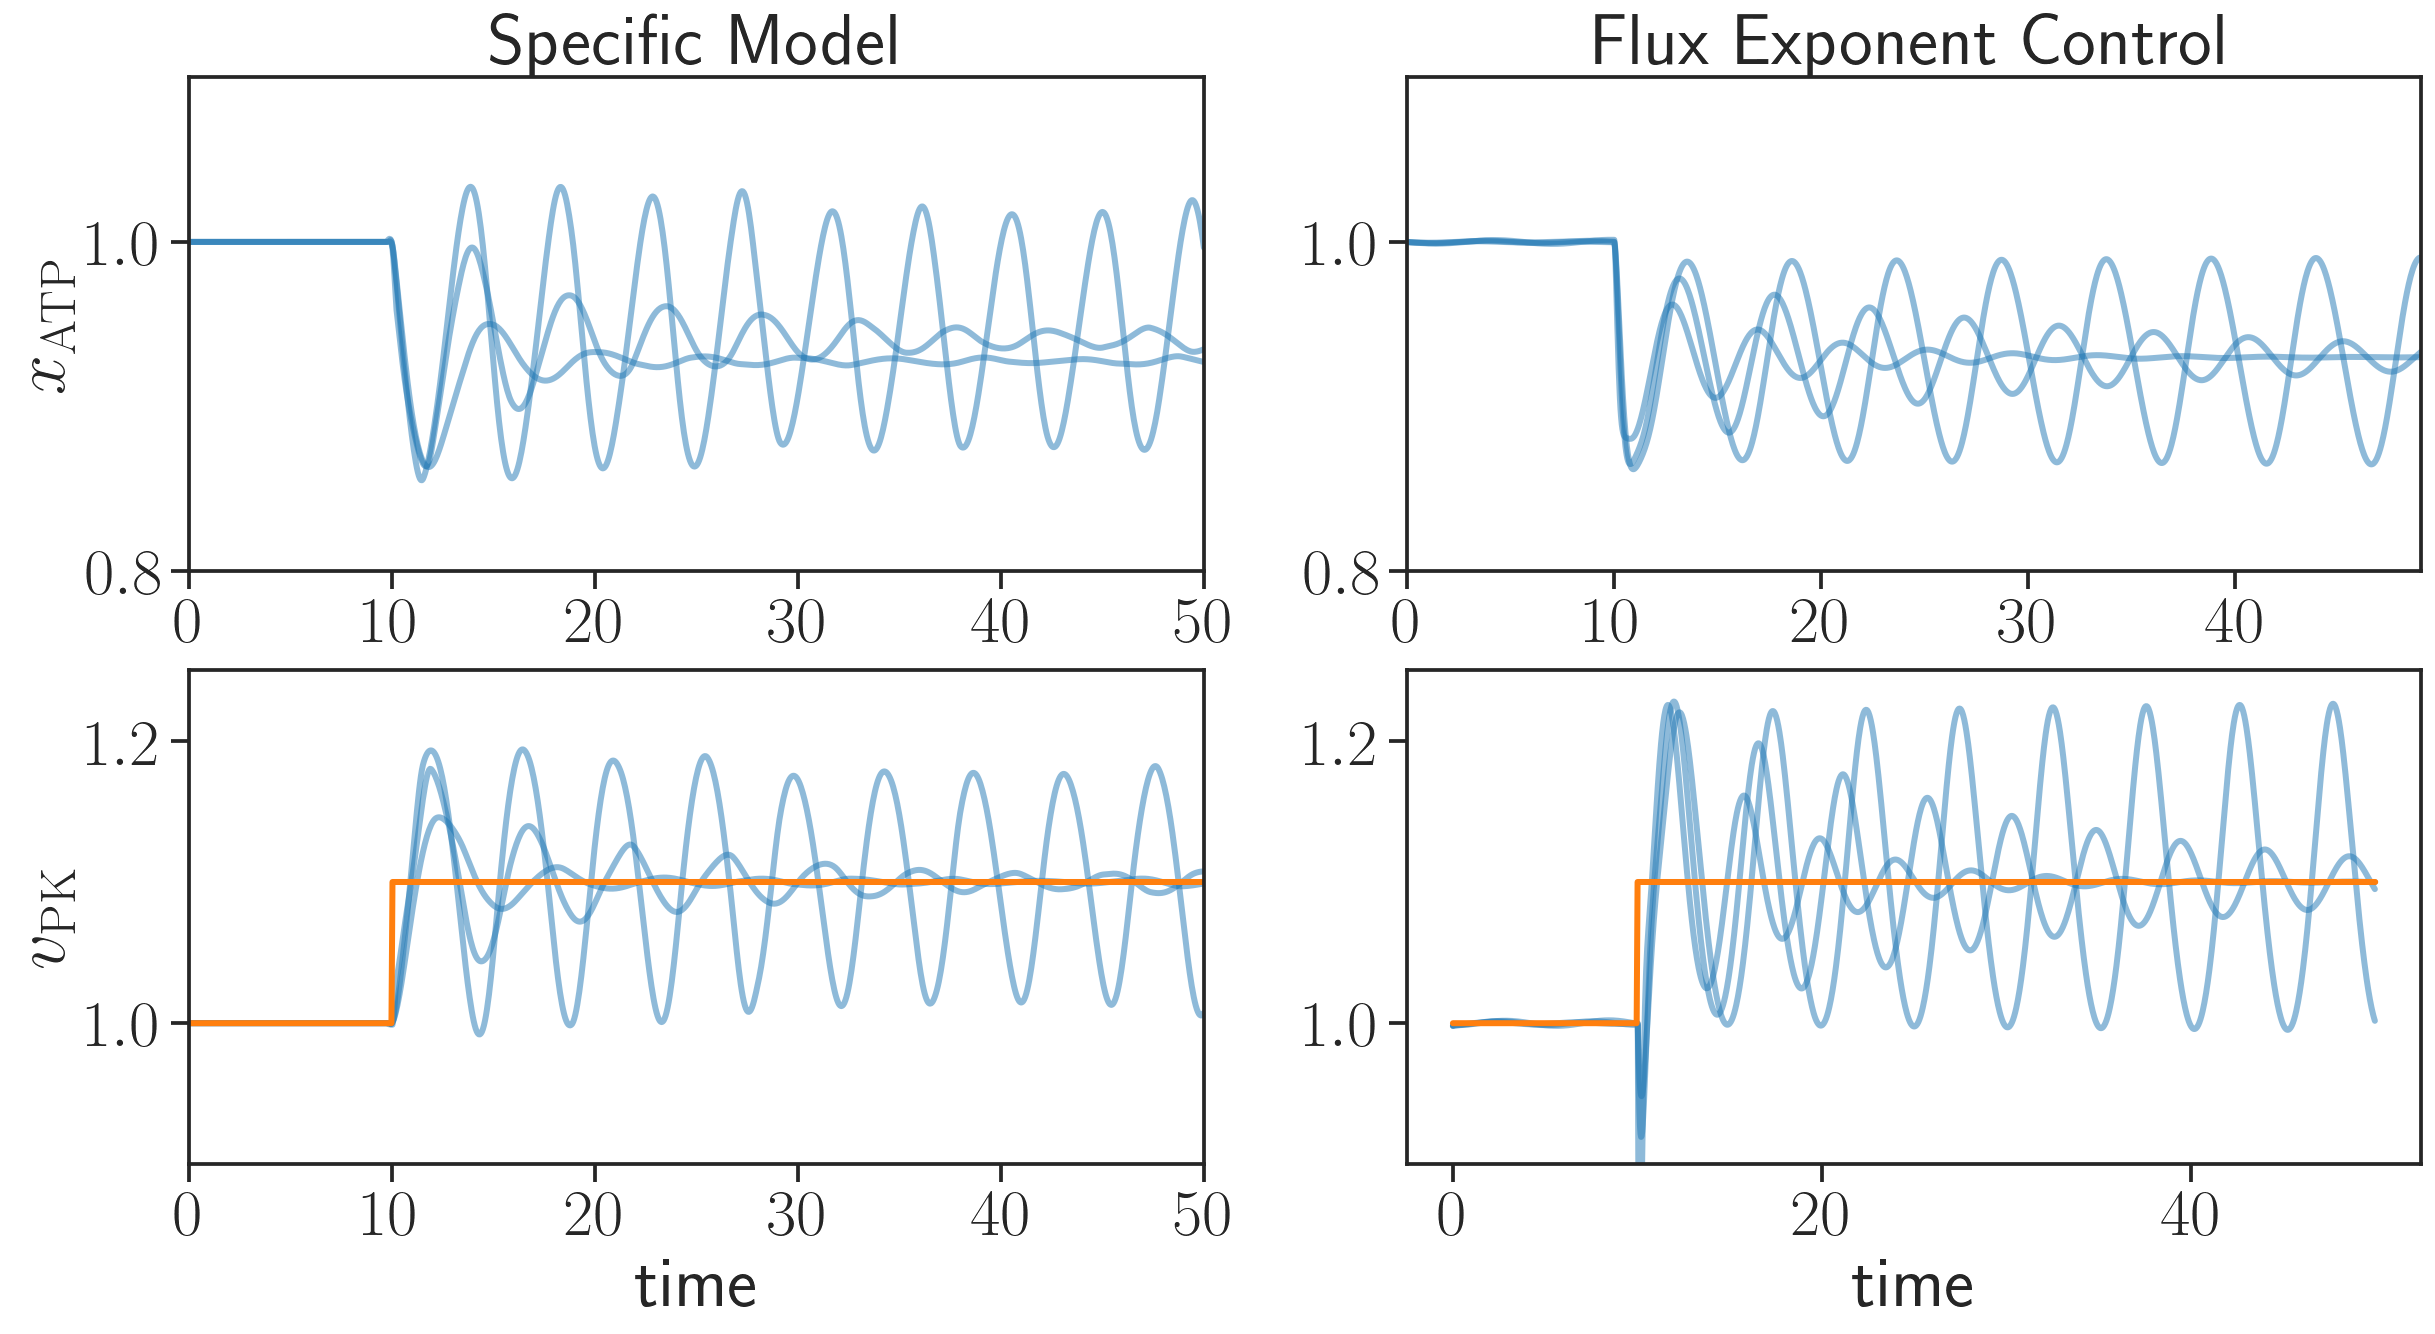

In [219]:
a=1
q=1
k=1.1
K=np.diag([2,2*k])
A=np.array([[0,a],[1,0]])
B=np.eye(2)
S=np.array([[1,-1],[-q,1+q]]) # order is PFK, PK.
Sw=np.array([0,-1])
w_func=lambda t:1+(t>10)*0.1
# w_func=lambda t:1.1

h=2.8
g=.3

params={'a':a,'h':h,'g':g,'K':K,'k':k}


def df2(t,x,w_func,S,Sw,params):
    a=params['a']
    h=params['h']
    g=params['g']
    K=params['K']
    c=np.array([x[1]**a/(1+x[1]**(2*h)), x[0]/(1+x[1]**(2*g))])
    v=K.dot(c)
    return S.dot(v)+Sw.dot(w_func(t))

h_list=[2.5,2.8,3.1]
params_list=[params.copy() for i in h_list]
for a,h in zip(params_list,h_list):
    a['h']=h

t_end=50
t_init=0
n_pts=1000
t=np.linspace(t_init,t_end,n_pts)
n_params=len(params_list)
n_dim=2
xtraj_list=np.zeros((n_params,n_dim,n_pts))
utraj_list=np.zeros((n_params,n_dim,n_pts))
vtraj_list=np.zeros((n_params,n_dim,n_pts))
for i,params in zip(range(n_params),params_list):
    f=lambda t,x:df2(t,x,w_func,S,Sw,params)
    k=params['k']
    a=params['a']
    h=params['h']
    g=params['g']
    K=params['K']
    x0=[1/k,1]
    sol = solve_ivp(f, [t_init,t_end], x0, t_eval=t)
#     import pdb
#     pdb.set_trace()
    xtraj=sol.y
    xtraj_list[i]=xtraj
    utraj=np.array([np.log(1/(1+xtraj[1]**(2*h))),np.log(1/(1+xtraj[1]**(2*g)))])
    ctraj=np.array([xtraj[1]**a/(1+xtraj[1]**(2*h)), xtraj[0]/(1+xtraj[1]**(2*g))])
#     import pdb
#     pdb.set_trace()
    vtraj=K.dot(ctraj)
    vtraj_list[i]=vtraj
    utraj_list[i]=utraj
    

fig, ax = plt.subplots(2, 2,figsize=(20,10))
for i in range(n_params):
    ax[0,0].plot(t,xtraj_list[i][1],color='#1f77b4',alpha=0.5)
    ax[1,0].plot(t,vtraj_list[i][1],color='#1f77b4',alpha=0.5)
ax[0,0].set_ylabel(r'\(x_{\mathrm{ATP}}\)')
ax[0,0].set_ylim([0.8,1.1])
ax[0,0].set_xlim([t_init,t_end])
ax[0,0].set_title('Specific Model')

ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel(r'\(v_{\mathrm{PK}}\)')
ax[1,0].set_ylim([.9,1.25])
ax[1,0].set_xlim([t_init,t_end])

ax[1,0].plot(t,w_func(t),color='#ff7f0e',label='FBA') #this is because in this setting, steady state flux of both PK and PFK are equal to disturbance w.


for i in range(nMPC_params):
    ax[0,1].plot(tMPC,xMPC_traj_list[i][1],color='#1f77b4',alpha=0.5)
    ax[1,1].plot(tMPC,vMPC_traj_list[i][1],color='#1f77b4',alpha=0.5)

ax[0,1].set_ylim([0.8,1.1])
ax[0,1].set_xlim([int(min(tMPC)),int(max(tMPC))])
ax[0,1].set_title('Flux Exponent Control')

ax[1,1].set_xlabel('time')
ax[1,1].set_ylim([.9,1.25])
ax[1,1].plot(t,w_func(t),color='#ff7f0e',label='FBA') #this is because in this setting, steady state flux of both PK and PFK are equal to disturbance w.

plt.savefig('glycolytic-oscillation-mpc-comparison.png',bbox_inches='tight')